In [2]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

## Минипроект

Опираясь на [карту](https://eusipa.org/wp-content/uploads/European_map_20160530_2016.pdf) Европейской ассоциации структурных инвестиционных
продуктов (EUSIPA) и ее [российскую адаптацию](https://naufor.ru/tree.asp?n=22890)

привести 2-3 ссылки на

*   структурные продукты, представленные на россиском рынке,
*   доступные наборы данных (напрмер, [HKEX](https://www.hkex.com.hk/Products/Securities/Structured-Products/Trading-Information-and-Historical-Data?sc_lang=en)).

https://www.moex.com/ru/issue.aspx?board=TQOB&code=SU26207RMFS9
https://www.moex.com/a8653

в целом на мосбирже много информации и доступ к разным инструментам, но можно пользоваться и другими брокерами

# Cтруктурный продукт с полной защитой капитала

## СП с использованием бинарных опционов

Пример. Имеется 0,1 млн рублей, которые клиент готов инвестировать на 1 год. Ожидается, что текущая цена акции, равная 100 руб., не изменится более чем на 10%. Волатильность акции – 30%, депозитная процентная ставка и безрисковая процентная
ставка – 7%.

Постройте структурный продукт с полной защитой капитала и использованием опционной стратегии бинарный диапазон (binary range).

In [3]:
# оценка стоимости бинарного опциона колл
def binary_option_call(t, S, K, T, r, q, sigma):

    d1 = (np.log(S/K) + (r+sigma**2/2)*(T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    if t == 'cash-or-nothing':
      return np.exp(-r*T)*norm.cdf(d2)
    if t == 'asset-or-nothing':
      return S*np.exp(-q*T)*norm.cdf(d1)

# оценка стоимости бинарного опциона пут
def binary_option_put(t, S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r+sigma**2/2)*(T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    if t == 'cash-or-nothing':
      return np.exp(-r*T)*norm.cdf(-d2)
    if t == 'asset-or-nothing':
      return S*np.exp(-q*T)*norm.cdf(-d1)

In [4]:
S = 100
K = 100
T = 1
r = 0.07
q = 0
N = 100000
sigma = 0.3
n = 100

In [5]:
K=90
b90 = binary_option_call('cash-or-nothing', S, K, T, r, q, sigma)
K=110
b110 = binary_option_call('cash-or-nothing', S, K, T, r, q, sigma)
print('digital range = ', b90-b110)

digital range =  0.24307515482345715


In [6]:
risk_part = N - N*np.exp(-r*T)
Q = round(risk_part/(b90-b110))
print('количество опционных стратегий', Q)

количество опционных стратегий 27813


In [7]:
print('максимальная доходность, годовых = ', (N+Q)/(N*T)-1)
print('максимальная доходность, непрерывно = ', np.log((N+Q)/(N*T)))

максимальная доходность, годовых =  0.27813
максимальная доходность, непрерывно =  0.24539807222181784


In [8]:
def call(S, K, T, sigma, r, q):
    d1 = (np.log (S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp (-r * T) * norm.cdf(d2)

Пример. Постройте график доходности структурного продукта в сравнении с доходностью базового актива и безрисковой ставки.

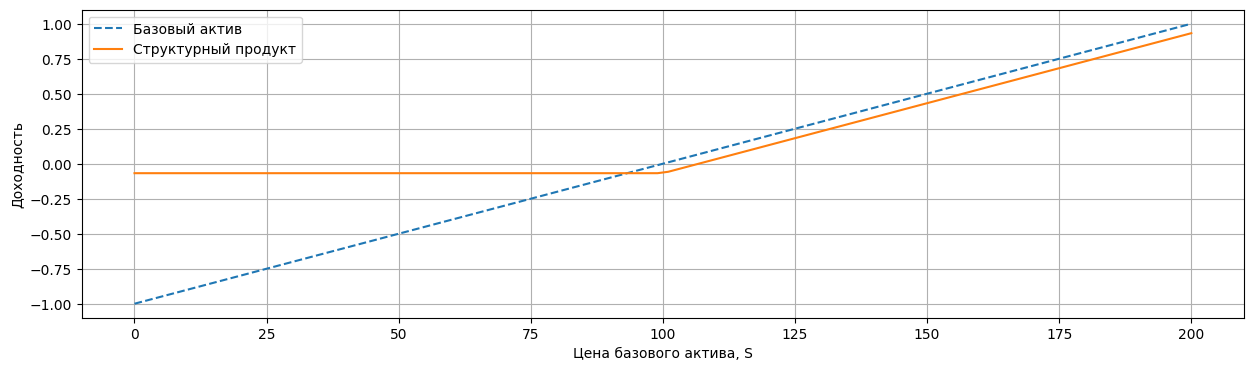

In [9]:
risk_part = N - N * np.exp(-r * T)
c = call(S, K, T, sigma, r, q)
PR = S * round(risk_part / c) / N

underlying_asset_profit = np.linspace(- S, S, n) / S
struct_product_profit = np.maximum(0, underlying_asset_profit) - round(risk_part / c) * c / N

x = np.linspace(0, 2 * S, n)
plt.figure(figsize=(15, 4))
#plt.title('Profit UA vs OC')
plt.plot(x, underlying_asset_profit, '--', label='Базовый актив')
plt.plot(x, struct_product_profit,  label='Структурный продукт')
plt.ylabel('Доходность')
plt.xlabel('Цена базового актива, S')
plt.grid()
plt.legend()
plt.show()

Пример. Постройте график зависимости коэффициента участия от встроенной комиссии, проварьируйте комиссию от 0 до 10% с шагом 1%.

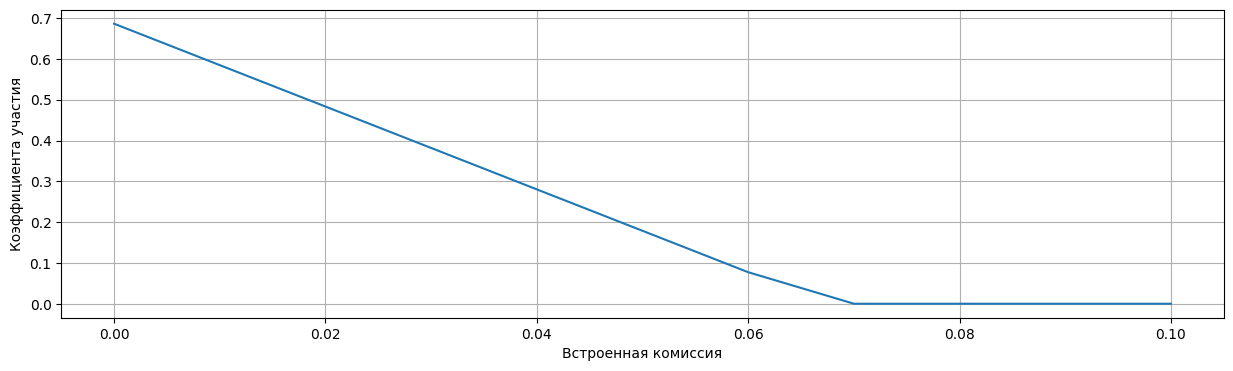

In [10]:
da = np.exp(-r * T) * N

Q = lambda fees: ( N * (1 - fees)  - da ) / c
fees = (np.linspace(0.0, 0.1, 11))
PR = K * Q(fees) / N

plt.figure(figsize=(15, 4))
#plt.title('PR from fees value')
plt.plot(fees, np.maximum(PR, 0))
plt.xlabel('Встроенная комиссия')
plt.ylabel('Коэффициента участия')
plt.grid()
plt.show()

Постройте график зависимости коэффициента участия от процентных ставок (депозитная и безрисковая ставки равны), проварьируйте ставки от 0 до 20% с шагом 1%.

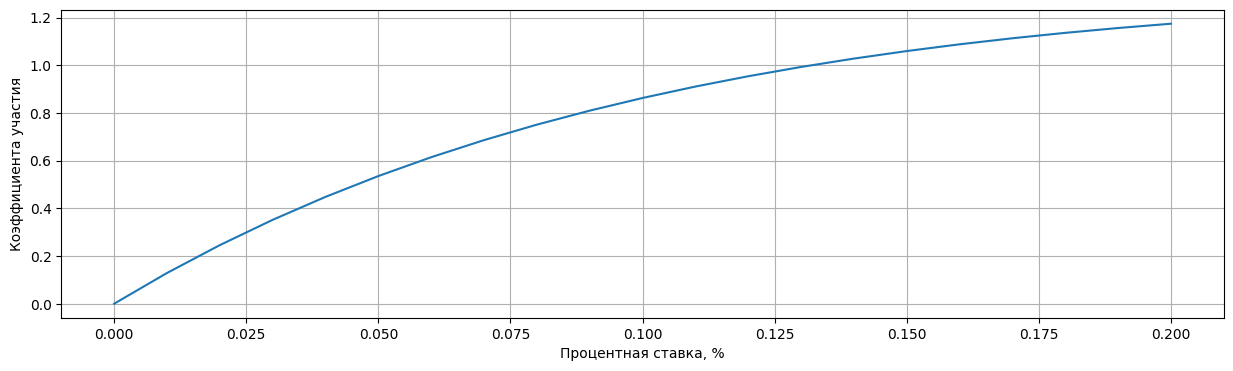

In [11]:
Q = lambda da, c: ( N * (1 - 0.0)  - da ) / c
rs = np.linspace(0, 0.2, 21)
cs = np.fromiter((call(S, K, T, sigma, ri, q) for ri in rs), dtype=np.float32)
das = np.exp(-rs * T) * N
Qs = np.fromiter((Q(da,c) for da,c in zip(das, cs)), dtype=np.float32)
PR = K * Qs / N

plt.figure(figsize=(15, 4))
#plt.title('PR from interest rate')
plt.plot(rs, np.maximum(PR, 0))
plt.xlabel('Процентная ставка, %')
plt.ylabel('Коэффициента участия')
plt.grid()
plt.show()

### Задача

Задача. Постройте трехмерных график зависимости коэффициента участия от депозитной и безрисковой ставок, проварьируйте ставки от 0 до 25% с шагом 1%.

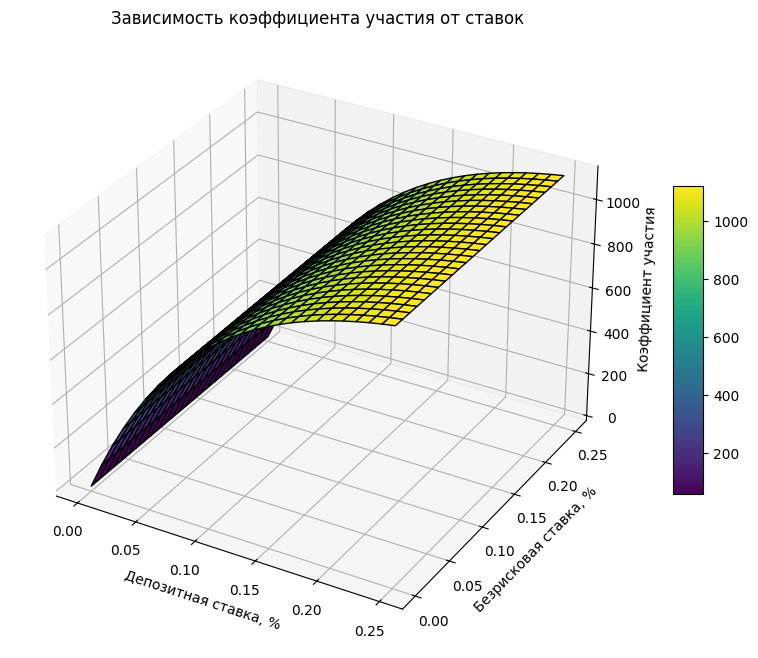

In [12]:
# Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Коэффициент участия
Q = lambda da, c: (N * (1 - q) - da) / c

r_deposit = np.linspace(0, 0.25, 26)  
r_risk_free = np.linspace(0, 0.25, 26)

R_deposit, R_risk_free = np.meshgrid(r_deposit, r_risk_free)


Cs = np.array([[call(S, K, T, sigma, rf, q) for rf in r_risk_free] for rd in r_deposit])
DAs = np.exp(-R_deposit * T) * N
Qs = (N * (1 - q) - DAs) / Cs


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(R_deposit, R_risk_free, Qs, cmap="viridis", edgecolor="k")

ax.set_title("Зависимость коэффициента участия от ставок")
ax.set_xlabel("Депозитная ставка, %")
ax.set_ylabel("Безрисковая ставка, %")
ax.set_zlabel("Коэффициент участия")
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()


Пример. Постройте график зависимости коэффициента участия от волатильности базового актива, проварьируйте волатильность от 0 до
100% с шагом 5%.

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_16530/102214163.py:4: RuntimeWarning: divide by zero encountered in divide
  Q = lambda c: ( N * (1 - 0.0)  - da ) / c


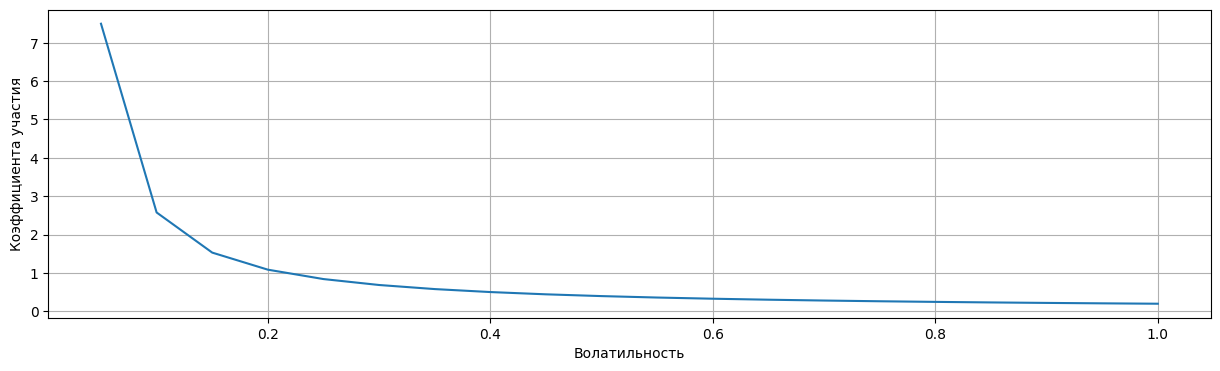

In [13]:
vs = np.linspace(1e-5, 1, 21)
cs = call(S, K, T, vs, r, q)
da = np.exp(-r * T) * N
Q = lambda c: ( N * (1 - 0.0)  - da ) / c
Qs = Q(cs)
PR = K * Qs / N

plt.figure(figsize=(15, 4))
#plt.title('PR from volatility')
plt.plot(vs, PR)
plt.xlabel('Волатильность')
plt.ylabel('Коэффициента участия')
plt.grid()
plt.show()

Пример. Постройте график влияния срока продукта (от 0 до 100 лет, с
шагом 6 месяцев) на соотношение безрискового и рискового вложений.

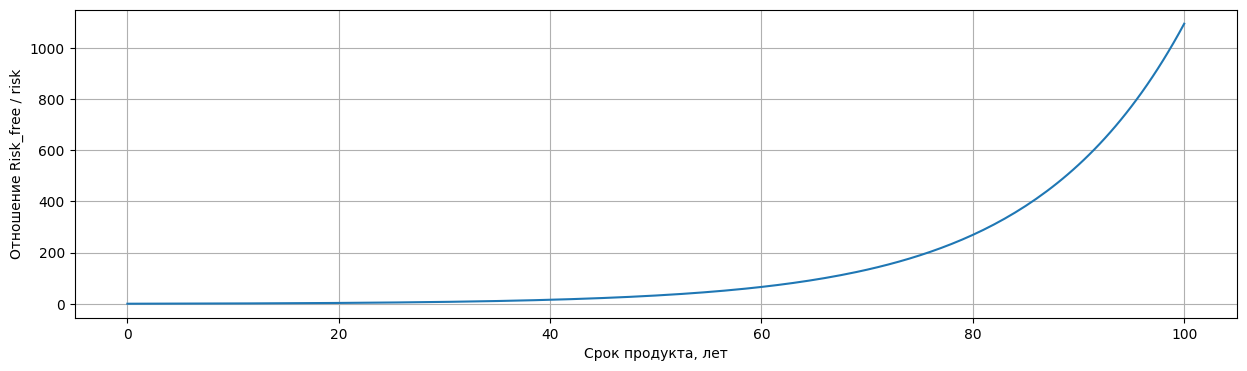

In [14]:
Ts = np.linspace(1e-5, 100, 201)
risk_parts = N - N * np.exp(-r * Ts)
ratios = risk_parts / (N - risk_parts)

plt.figure(figsize=(15, 4))
#plt.title('Risk-free to risk fraction relation on maturity date')
plt.plot(Ts, ratios)
plt.xlabel('Срок продукта, лет')
plt.ylabel('Отношение Risk_free / risk')
plt.grid()
plt.show()

Пример. Постройте график зависимости коэффициента участия от срока
продукта (от 0 до 20 лет, с шагом 6 месяцев).


/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_16530/4026867300.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  Q = lambda c, d: ( N * (1 - 0.0)  - d ) / c


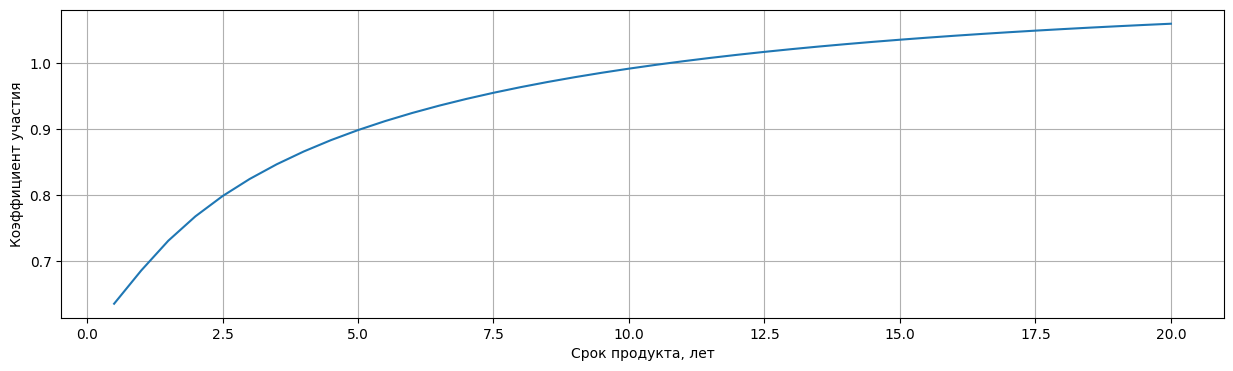

In [15]:
Ts = np.linspace(1e-5, 20, 41)
cs = call(S, K, Ts, sigma, r, q)
das = np.exp(-r * Ts) * N
Q = lambda c, d: ( N * (1 - 0.0)  - d ) / c
Qs = np.fromiter((Q(c, d) for c,d in zip(cs, das)), dtype=np.float64)
PR = K * Qs / N

plt.figure(figsize=(15, 4))
#plt.title('PR from maturity date')
plt.plot(Ts, PR)
plt.xlabel('Срок продукта, лет')
plt.ylabel('Коэффициент участия')
plt.grid()
plt.show()

Пример. Постройте график коэффициента участия от страйка продукта
(от 80 до 140, с шагом 10).

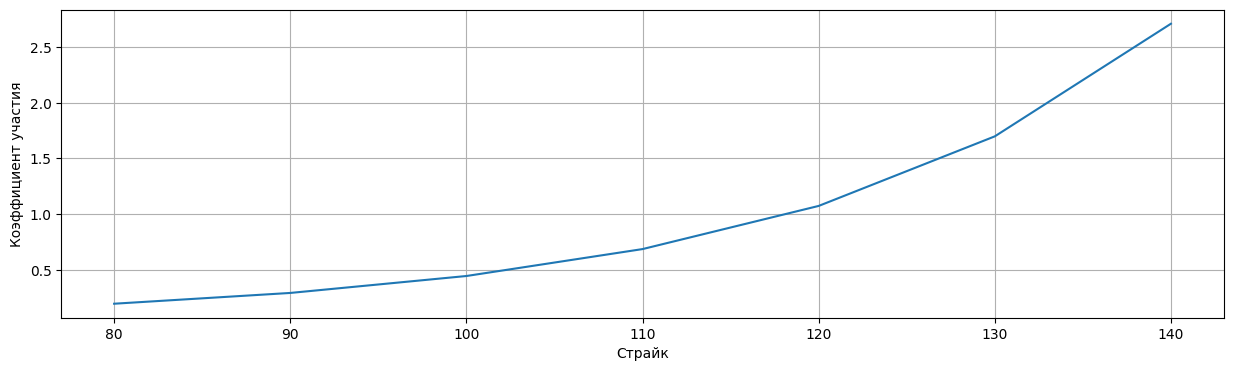

In [16]:
Ks = np.linspace(80, 140, 7)
cs = call(S, Ks, T,  sigma, r, q)
da = np.exp(-r * T) * N
Q = lambda c: ( N * (1 - 0.0)  - da ) / c
Qs = Q(cs)
PR = np.fromiter(((Kv * Qv / N) for Kv, Qv in zip(Ks, Qs)), dtype=np.float32)

plt.figure(figsize=(15, 4))
#plt.title('PR from strike')
plt.plot(Ks, PR)
plt.xlabel('Страйк')
plt.ylabel('Коэффициент участия')
plt.grid()
plt.show()

Пример. Постройте график доходности продуктов с разными страйками и
100% защитой капитала.

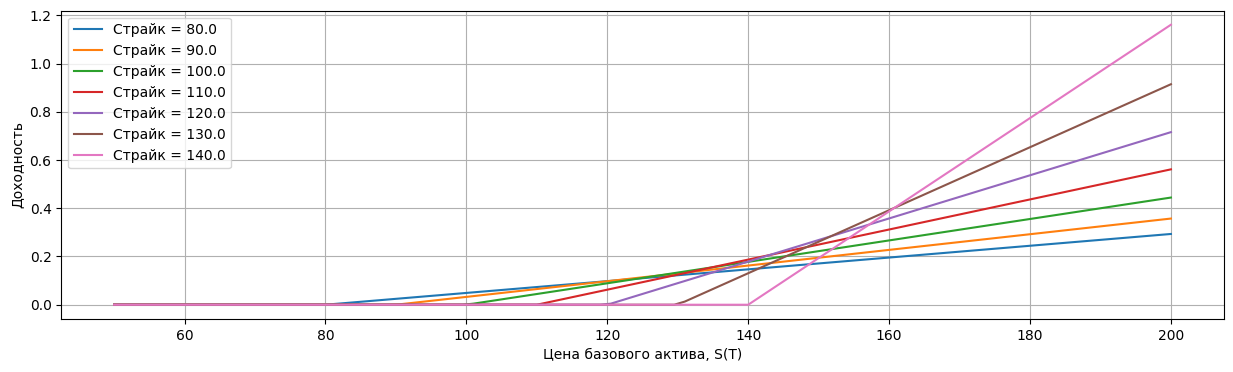

In [17]:
Ks = np.linspace(80, 140, 7)

cs = call(S, Ks, T, sigma, r, q)
da = np.exp(-r * T) * N
Q = lambda c: ( N * (1 - 0.0)  - da) / c
Qs = Q(cs)
# Qs = np.fromiter((Q(c) for c in zip(cs, das)), dtype=np.float64)
PR = np.fromiter(((Kv * Qv / N) for Kv, Qv in zip(Ks, Qs)), dtype=np.float32)
Sm = np.linspace(0.5*S, 2*S, 101)

plt.figure(figsize=(15, 4))
#plt.title('Profit on UA')
for i, pr in enumerate(PR):
    rs = np.maximum(0, pr * (Sm - Ks[i]) / Ks[i])
    plt.plot(Sm, rs, label=f'Страйк = {Ks[i]}')
plt.xlabel('Цена базового актива, S(T)')
plt.ylabel('Доходность')
plt.legend()
plt.grid()
plt.show()

Пример. Постройте графики доходностей продуктов с одним страйком и
разной степенью защиты капитала (от 80% до 150%, с шагом 10%)

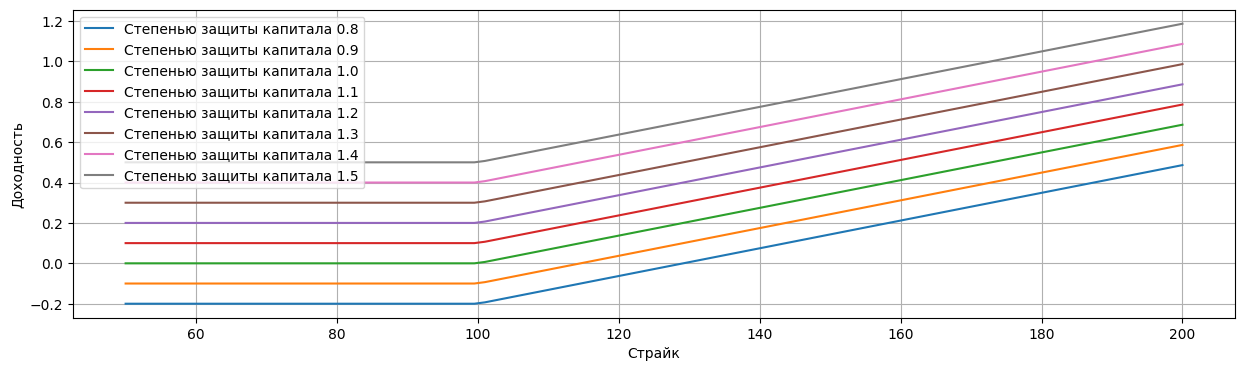

In [18]:
gs = np.linspace(0.8, 1.5, 8)
c = call(S, K, T, sigma, r, q)
da = np.exp(-r * T) * N
Q = lambda c: ( N * (1 - 0.0)  - da ) / c
PR = K * Q(c) / N
Sm = np.linspace(0.5*S, 2*S, 101)

plt.figure(figsize=(15, 4))
#plt.title('PR from strike')
for i, g in enumerate(gs):
    returns = np.maximum(g - 1, (g - 1) + PR * (Sm - S)/S)
    plt.plot(Sm, returns, label=f'Степенью защиты капитала {g}')
plt.xlabel('Страйк')
plt.ylabel('Доходность')
plt.legend()
plt.grid()
plt.show()

### Задача

Задача. В условиях примера постройте 3D график зависимости доходности структурного продукта от

*   страйков и
*   степени защиты капитала.

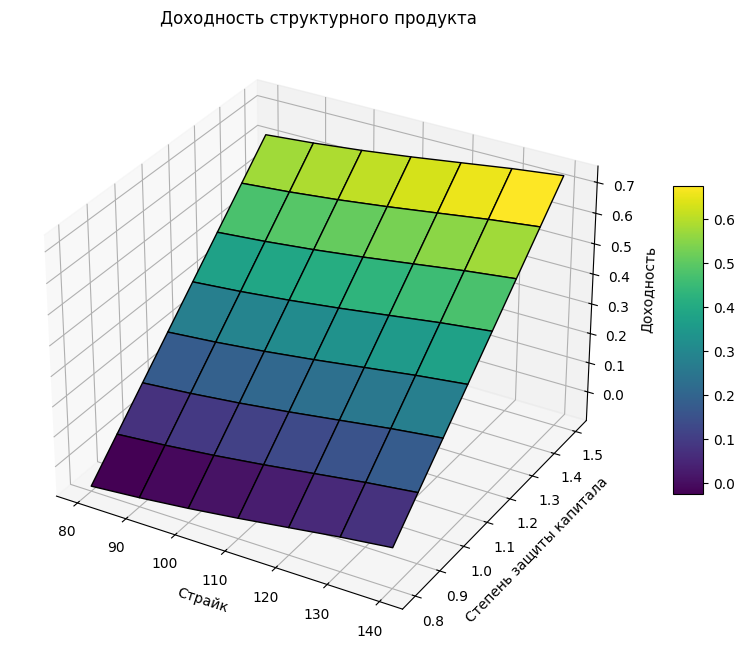

In [19]:
Ks = np.linspace(80, 140, 7) 
gs = np.linspace(0.8, 1.5, 8)


K_grid, g_grid = np.meshgrid(Ks, gs)
Sm = np.linspace(0.5 * S, 2 * S, 101)

# считаем для каждого страйка и потом дисконтируем
cs = np.array([call(S, K, T, sigma, r, q) for K in Ks])
da = np.exp(-r * T) * N  
Q = lambda c: (N * (1. - .0) - da) / c 
Qs = Q(cs)


returns = np.zeros_like(K_grid, dtype=np.float64)
for i, K_value in enumerate(Ks):
    for j, g_value in enumerate(gs):
        PR = K_value * Qs[i] / N  
        rs = np.maximum(g_value - 1, (g_value - 1) + PR * (Sm - K_value) / K_value)
        returns[j, i] = rs.mean()  


#######

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(K_grid, g_grid, returns, cmap='viridis', edgecolor='k')

ax.set_title("Доходность структурного продукта")
ax.set_xlabel("Страйк")
ax.set_ylabel("Степень защиты капитала")
ax.set_zlabel("Доходность")
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()


Пример. В условиях примера для опциона колл повторите все расчеты с использованием бинарной стратегии, основанной на покупке и продаже европейского опциона пут.

Ширину диапазона доходности базового актива задать самостоятельно. Выбор обосновать.

In [20]:
S = 100
K = 100
T = 1
r = 0.07
q = 0
N = 100000
sigma = 0.3

K1 = 100
bo1 = binary_option_put('cash-or-nothing', S, K1, T, r, q, sigma)
K2=110
bo2 = binary_option_put('cash-or-nothing', S, K2, T, r, q, sigma)
print('digital range = ', -bo1+bo2)

risk_part = N - N*np.exp(-r*T)
Q = round(risk_part/(-bo1+bo2))
print('количество опционных стратегий', Q)

print('максимальная доходность, годовых = ', (N+Q)/(N*T)-1)
print('максимальная доходность, непрерывно = ', np.log((N+Q)/(N*T)))

digital range =  0.11734811871736428
количество опционных стратегий 57612
максимальная доходность, годовых =  0.57612
максимальная доходность, непрерывно =  0.45496613066900204


Пример. Постройте график функции выплат для бинарных стратегий, основанных
*   на покупке и продаже опционов колл,
*  на покупке и продаже опционов пут.



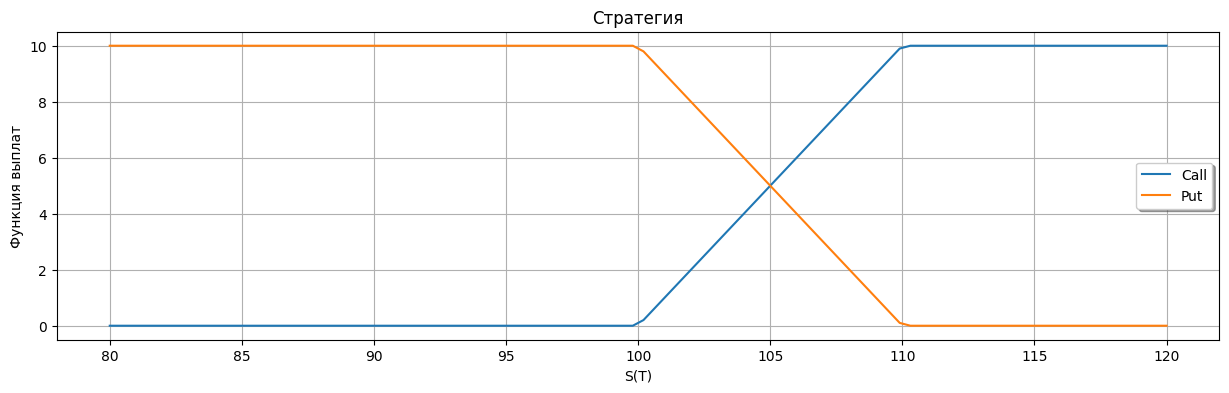

In [21]:
S = np.linspace(80, 120, 100)

C1 = np.maximum(S - K1, 0)
C2 = np.maximum(S - K2, 0)

P1 = np.maximum(-S + K1, 0)
P2 = np.maximum(-S + K2, 0)
plt.figure(figsize=(15,4))
plt.plot(S, C1 - C2, label=f'Call')
plt.plot(S, -P1 + P2, label=f'Put')
plt.legend(loc = 'best', fancybox = True, shadow = True)

plt.xlabel(f"S(T)")
plt.ylabel("Функция выплат")
plt.title("Стратегия")

plt.grid(True)
plt.show()

### Задача

Задача. Постройте графики трехмерных поверхностей для описания зависимости коэффициента участия при использовании бинарных опционов  
*   кол,
*   пут

от стоимости базового актива и количества дней до экспирации.

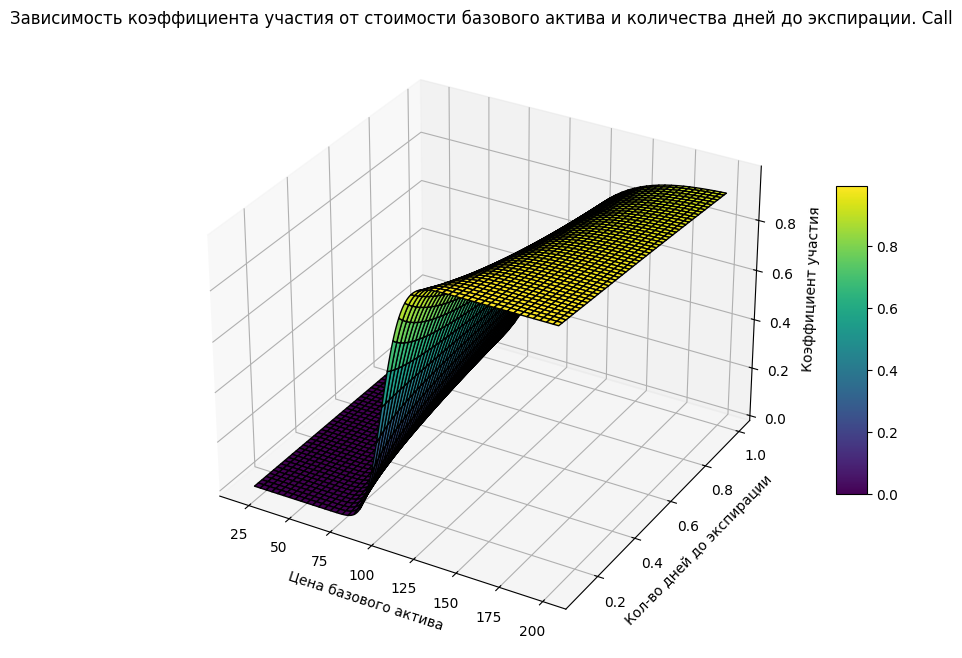

In [29]:
sigma = 0.3
K = 100
# Коэффициент участия
Q = lambda da, c: (N * (1 - q) - da) / c

tau = np.linspace(0.1, 1, 300)
S = np.linspace(20, 200, 300)

S_grid, Tau_grid = np.meshgrid(S, tau)


# Cs = np.array([[ binary_option_call('cash-or-nothing', s, K, t, sigma, r, q) for s in S] for t in tau])
Cs = binary_option_call('cash-or-nothing', S_grid, K, Tau_grid, r, q, sigma)

DAs = np.exp(-r * Tau_grid) * N
Qs = np.where(Cs > 0, (N * (1 - q) - DAs) / Cs, 0)



fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(S_grid, Tau_grid, Cs, cmap="viridis", edgecolor="k")

ax.set_title("Зависимость коэффициента участия от стоимости базового актива и количества дней до экспирации. Call")
ax.set_xlabel("Цена базового актива")
ax.set_ylabel("Кол-во дней до экспирации")
ax.set_zlabel("Коэффициент участия")
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()

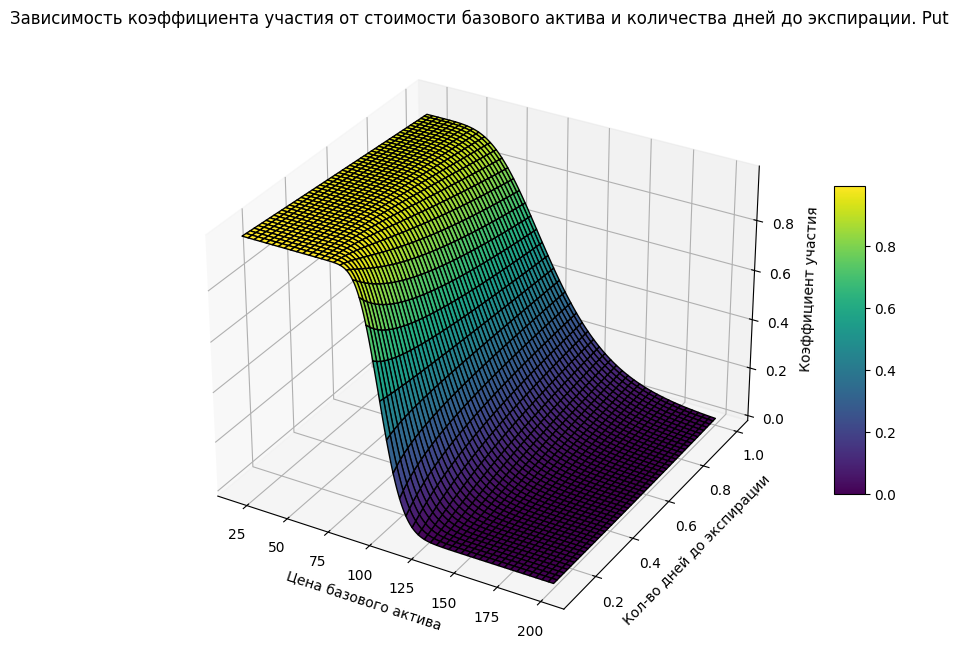

In [33]:
sigma = 0.3
K = 100
# Коэффициент участия
Q = lambda da, c: (N * (1 - q) - da) / c

tau = np.linspace(0.1, 1, 300)
S = np.linspace(20, 200, 300)

S_grid, Tau_grid = np.meshgrid(S, tau)


Cs = binary_option_put('cash-or-nothing', S_grid, K, Tau_grid, r, q, sigma)

DAs = np.exp(-r * Tau_grid) * N
Qs = np.where(Cs > 0, (N * (1 - q) - DAs) / Cs, 0)



fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(S_grid, Tau_grid, Cs, cmap="viridis", edgecolor="k")

ax.set_title("Зависимость коэффициента участия от стоимости базового актива и количества дней до экспирации. Put")
ax.set_xlabel("Цена базового актива")
ax.set_ylabel("Кол-во дней до экспирации")
ax.set_zlabel("Коэффициент участия")
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()

## CП с использованием гэп опционов

### Задача

Задача. Рассмотрим гэп опционы колл и пут на недивидендные акции со страйком 57 и сроком действия, истекающим 1 июля следующего года, на 1 января текущего года акции торгуются по цене 50.

Используя эти данные, вычислите цену опциона колл и пут, если безрисковая ставка равна 9%, цена страйк 50, волатильность 20%.

In [35]:
S = 50 
K1 = 57   
K2 = 50  
r = 0.09 
sigma = 0.2  
T = 0.5  # 6 месяцев
q = 0.0       

d1 = (np.log(S / K1) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

C = np.exp(-r * T) * (S * np.exp((r - q) * T) * norm.cdf(d1) - K2 * norm.cdf(d2))

P = np.exp(-r * T) * (K2 * norm.cdf(-d2) - S * np.exp((r - q) * T) * norm.cdf(-d1))

print(f'Цена кол: {C}')
print(f'Цена пут: {P}')

Цена кол: 2.89008843746616
Цена пут: 0.6899625291211517


В рамках модели Блэка-Шоулза решите следующие задачи для бинарных опционов.

Пример. Маркет-мейкер продает европейские гэп-колл опционы сумму 1000 сроком на один год и дельта-хеджирует позицию акциями.
Опцион гэп-колл выписан на одну акцию, не приносящую дивидендов. Текущая цена акции составляет 100.

Волатильность акции составляет 100\%. Каждый колл-гэп опцион  имеет цену исполнения 130, триггер цена равна  100. Безрисковая процентная ставка равна 0\%.

В рамках модели Блэка-Шоулза определите начальное количество акций для  дельта-хеджирования.

**Указание.** Определите дельту опциона и умножьте на 1000.

In [36]:
def first_derivative (f , x , args, h = 0.0001) :
    return (f(x + h, *args) - f(x - h, *args)) / (2 * h)

In [37]:
S = 100
K1 = 130 # strike
K2 = 100 # trigger
r = 0.0
sigma = 1
T = 1
q = 0


def calc_d1(S, K, T, r, q, sigma):
    return (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

def calc_d2(S, K, T, r, q, sigma):
    return calc_d1(S, K, T, r, q, sigma) - sigma * np.sqrt(T)

def gap_option_price_call(S, K1, K2, T, r, q, sigma):
    d1 = calc_d1(S, K1, T, r, q, sigma)
    d2 = calc_d2(S, K1, T, r, q, sigma)
    price = S * np.exp(-q * T) * norm.cdf(d1) - K2 * np.exp(-r * T) * norm.cdf(d2)
    return price

def gap_option_price_put(S, K1, K2, T, r, q, sigma):
    d1 = calc_d1(S, K2, T, r, q, sigma)
    d2 = calc_d2(S, K2, T, r, q, sigma)
    price = K2 * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    return price


def first_derivative(f, x, args, h=1e-3):
    return (f(x + h, *args) - f(x - h, *args)) / (2 * h)

c = gap_option_price_call(S, K1, K2, T, r, q, sigma)
delta = first_derivative(gap_option_price_call, S, (K1, K2, T, r, q, sigma))

print(f'Цена опциона: {c}')
print(f'Дельта: {delta * 1000}')

Цена опциона: 37.09968701695299
Дельта: 683.4186927022756


### Задача

Задача. В условиях примера определите начальное количество акций для дельта-хеджирования с использованием пут-гэп опционов. Выбор цены исполнения и триггер цены обосновать.

In [38]:
S = 100        
K1 = 130
K2 = 100       
r = 0.0        
sigma = 1.
T = 1
q = 0


p = gap_option_price_put(S, K1, K2, T, r, q, sigma)
delta = first_derivative(gap_option_price_put, S, (K1, K2, T, r, q, sigma))
number_of_shares = delta * 1000  

print(f"Цена пут-гэп опциона: {p}")
print(f"Дельта опциона: {delta}")
print(f"Начальное количество акций для дельта-хеджирования: {round(number_of_shares)}")

Цена пут-гэп опциона: 38.292492254802625
Дельта опциона: -0.3085375387357203
Начальное количество акций для дельта-хеджирования: -309


цену исполнения и тригер взял из постановки задачи примера

Пример. Безрисковая процентная ставка составляет 6%, волатильность бездивидендных акций составляет 32%. Четырехлетний опцион пут «деньги или ничего» на эту акцию с триггерной ценой 135 имеет премию 0,32494. Найдите цену 4-летнего опциона колл «актив или ничего» на эту акцию с триггерной ценой 135.

In [39]:
r = 0.06
sigma = 0.32
T = 4
K = 135
q = 0
put = 0.32494
put_type = 'cash-or-nothing'

opt_func = lambda x: binary_option_put(put_type, x, K, T, r, q, sigma) - put
S = fsolve(opt_func, K)[0]

call_type = 'asset-or-nothing'
call = binary_option_call(call_type, S, K, T, r, q, sigma)
call

120.75083564309931

Пример. Волатильность базового актива 25%, волатильность годового опциона колл со страйком 50 на акции составляет 120,68%. Маркет-мейкер выписывает один опцион колл и дельта хеджирует свою позицию. Стоимость акции в хеджирующем портфеле равна 34,74. Найдите цену годового опциона «деньги или ничего» колл на акцию с триггерной ценой 50.

In [40]:
r = 0.00
sigma_S = 0.25
sigma_call = 1.2068
K = 50
T = 1
K2 = 50
S_hedge = 34.74
q = 0
call_type = 'cash-or-nothing'
call = binary_option_call(call_type, S_hedge, K, T, r, q, sigma_S)
call

0.05687902614969493

### Задача

Задача. На акции по текущей цене 75 выплачивают дивиденды по ставке 2% (непрырывное начисление), волатильность акций 40%. Коэффициент Шарпа для акции равен 0. Шестимесячный опцион «актив или ничего» колл на акцию с триггером 80 стоит 36,65.

Рассчитайте вероятность того, что опцион колл «актив или ничего» будет исполнен.

В условиях примера проанализируйте зависимость вероятности исполнения опциона колл «актив или ничего» от коэффициента Шарпа.

Приведите иллюстративные графики.

In [70]:
t = 1/2
S0 = 75
sigma = 0.4
q = 0.02
Sharpe = -.0
r = 0.07
c = 36.65
K2 = 80

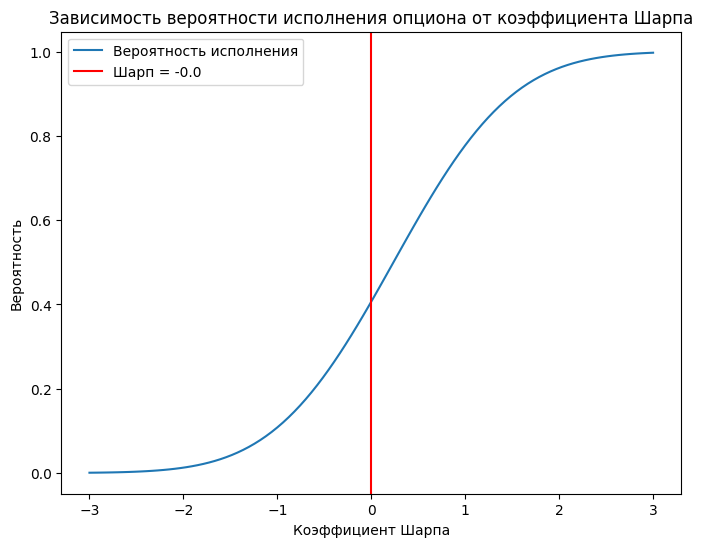

In [71]:
sharpe_ratios = np.linspace(-3, 3, 100)

probabilities = []
for sharpe in sharpe_ratios:

    probability = norm.cdf(calc_d2(S0, K2, T, r + sharpe * sigma, q, sigma))
    probabilities.append(probability)


plt.figure(figsize=(8, 6))
plt.plot(sharpe_ratios, probabilities, label="Вероятность исполнения")
plt.axvline(x=Sharpe, color='r', label=f"Шарп = {Sharpe}")
plt.title("Зависимость вероятности исполнения опциона от коэффициента Шарпа")
plt.xlabel("Коэффициент Шарпа")
plt.ylabel("Вероятность")
plt.legend()
plt.show()